# Twitter Sentiment Analysis

## Step 1: Importing the Required Libraries

Before we start analyzing Twitter sentiment, we need to import several essential Python libraries for:
- **Data Handling:** `pandas` for structured data manipulation.
- **Data Visualization:** `matplotlib` and `seaborn` for visualizing tweet statistics.
- **Text Processing:** `nltk` and `TextBlob` for tokenization, stopword removal, lemmatization, and basic NLP tasks.
- **Machine Learning:** `scikit-learn` for feature extraction (TF-IDF, CountVectorizer), classification (Naïve Bayes), and evaluation metrics.
- **Pipeline Visualization:** `graphviz` to visualize the ML workflow.

Additionally, we will **download important NLTK resources** such as stopwords, tokenizers, and corpora to process tweets effectively.

In [27]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import set_config
from graphviz import Digraph

# Fix SSL certificate issue for downloading resources (for some systems)
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download necessary NLTK resources
nltk.download('punkt')  # Tokenization
nltk.download('stopwords')  # Stopword removal
nltk.download('wordnet')  # Lemmatization
nltk.download('averaged_perceptron_tagger')  # POS tagging
nltk.download('brown')  # Corpus for NLP tasks
nltk.download('conll2000')  # Corpus for NLP tasks
nltk.download('movie_reviews') # Corpus for sentiment analysis

print("All necessary libraries and NLTK resources have been successfully loaded!")

All necessary libraries and NLTK resources have been successfully loaded!


[nltk_data] Downloading package punkt to /Users/maranmaxi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maranmaxi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maranmaxi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/maranmaxi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /Users/maranmaxi/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/maranmaxi/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/maranmaxi/nltk_data...
[nltk_data]   Package movie_

## Step 2: Reading the Data

To perform sentiment analysis, we need to load and inspect the dataset. The dataset contains:
- **Train Data:** Labeled tweets used for training the model.
- **Test Data:** Unlabeled tweets for making predictions.

Each dataset is stored in a **CSV file**. We will:
1. Define the file paths.
2. Load the datasets using `pandas.read_csv()`.
3. Display a preview of the data to verify it was loaded correctly.


In [28]:
# Define file paths for the datasets
train_path = "/Users/maranmaxi/Downloads/Twitter Sentiment Analysis/Data/train_tweets.csv"
test_path = "/Users/maranmaxi/Downloads/Twitter Sentiment Analysis/Data/test_tweets.csv"

In [29]:
# Load CSV files into pandas DataFrames
train_tweets = pd.read_csv(train_path)
test_tweets = pd.read_csv(test_path)

# Display first few rows to verify the data
print("Training Data Sample:")
print(train_tweets.head())

print("\nTest Data Sample:")
print(test_tweets.head())


Training Data Sample:
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

Test Data Sample:
      id                                              tweet
0  31963  #studiolife #aislife #requires #passion #dedic...
1  31964   @user #white #supremacists want everyone to s...
2  31965  safe ways to heal your #acne!!    #altwaystohe...
3  31966  is the hp and the cursed child book up for res...
4  31967    3rd #bihday to my amazing, hilarious #nephew...


### Selecting Relevant Columns

To ensure consistency and avoid unnecessary data, we extract only the columns needed for analysis:
- **Training Data**: We retain the `label` (sentiment) and `tweet` text.
- **Test Data**: Since test data is unlabeled, we keep only the `tweet` column.


In [30]:
# Selecting only the required columns
train_tweets = train_tweets[['label', 'tweet']]
test = test_tweets['tweet']

# Display dataset shape after column selection
print(f"Training Data Shape: {train_tweets.shape}")
print(f"Test Data Shape: {test.shape}")


Training Data Shape: (31962, 2)
Test Data Shape: (17197,)


## Step 3: Exploratory Data Analysis (EDA)

Before preprocessing and training our sentiment analysis model, it's essential to explore the dataset. **EDA helps us understand patterns, potential biases, and key characteristics of the data.**

### Key Areas of Analysis:
1. **Tweet Length Distribution** – Analyzing the average word length per sentiment class.
2. **Class Distribution** – Checking whether the dataset is balanced or skewed.

Visualizing these patterns helps us determine if we need additional preprocessing steps (e.g., balancing classes, removing outliers).


/var/folders/py/z5lnlzrs5f51g878kw89h44m0000gp/T/ipykernel_19383/3549722852.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='length', data=train_tweets, palette='coolwarm')


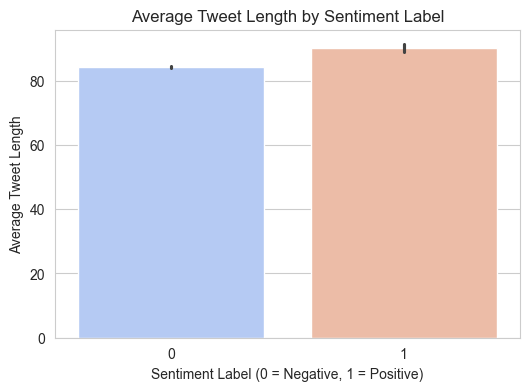

In [31]:
# Calculate tweet length
train_tweets['length'] = train_tweets['tweet'].apply(len)

# Create a bar plot for average word length by label
plt.figure(figsize=(6,4))
sns.barplot(x='label', y='length', data=train_tweets, palette='coolwarm')

# Customize plot
plt.title('Average Tweet Length by Sentiment Label')
plt.xlabel('Sentiment Label (0 = Negative, 1 = Positive)')
plt.ylabel('Average Tweet Length')
plt.show()


### Why This Is Important?
- Helps determine if **tweet length varies by sentiment** (e.g., do negative tweets tend to be longer?).
- If there’s a **significant length difference**, we may consider trimming or padding tweets for consistency.


/var/folders/py/z5lnlzrs5f51g878kw89h44m0000gp/T/ipykernel_19383/2970466048.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_tweets, palette='pastel')


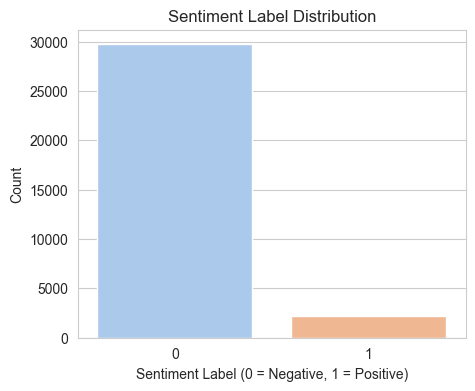

In [32]:
# Plot the count of each sentiment label
plt.figure(figsize=(5,4))
sns.countplot(x='label', data=train_tweets, palette='pastel')

# Customize plot
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()


### Why This Is Important?
- Helps us determine if the dataset is **balanced or imbalanced**.
- If one class is overrepresented, we might need **resampling techniques** (e.g., oversampling, undersampling) to prevent bias in the model.

## Step 4: Feature Engineering

In this stage, we transform raw textual data into meaningful features that machine learning models can understand. Common steps include:

- **Tokenization**: Splitting text into individual words or tokens.  
- **Removing Stopwords**: Filtering out common words (e.g., *the*, *and*, *but*) that don’t contribute much to sentiment.  
- **Lemmatization**: Converting words to their base form (e.g., *running* → *run*).  
- **Vectorization**: Converting text into numerical vectors via methods like **TF-IDF** or **Bag-of-Words**.

These transformations are vital for preparing the data so a machine learning model can effectively learn patterns and make accurate predictions.

### Tweet Preprocessing Overview

Before we feed tweets into a model, we must clean and standardize the text. Our preprocessing steps include:

1. **Tokenization** – Splitting a tweet into individual words.
2. **Stopword Removal** – Removing common words (e.g., *the*, *is*, *and*) that don’t add much meaning.
3. **Lemmatization** – Converting words to their base form (e.g., *running* → *run*).
4. **Removing Mentions & Special Characters** – Eliminating `@user` mentions, hashtags, numbers, and unnecessary symbols.

Let's go through each step with examples.


In [33]:
# Function to extract words from a tweet using TextBlob
def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

# Example: Tokenizing a tweet
print("Original Tweet:", train_tweets['tweet'].iloc[10])
print("Tokenized Tweet:", form_sentence(train_tweets['tweet'].iloc[10]))

Original Tweet:  â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex
Tokenized Tweet: â ireland consumer price index mom climbed from previous 0.2 to 0.5 in may blog silver gold forex


### Why Is This Important?

Tokenization is the first step in text preprocessing. By breaking down tweets into individual words, we can analyze the text more effectively.

- Prepares text for NLP tasks like sentiment analysis.
- Helps remove unnecessary symbols and punctuation.
- Converts text into a structured format for machine learning.


### Cleaning Tweets: Removing Stopwords & Special Characters

To reduce noise in the dataset, we:
- Remove **@user mentions** (common in tweets).
- Remove **non-alphabetic characters** (numbers, punctuation).
- Filter out **stopwords** (words that don’t contribute to sentiment).


In [34]:
from nltk.corpus import stopwords

# Function to clean tweets by removing "user", special characters, and stopwords
def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

# Example usage
print("Original Tweet:", train_tweets['tweet'].iloc[10])
print("Cleaned Tweet:", no_user_alpha(form_sentence(train_tweets['tweet'].iloc[10])))

Original Tweet:  â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex
Cleaned Tweet: ['ireland', 'consumer', 'price', 'index', 'mom', 'climbed', 'previous', 'may', 'blog', 'silver', 'gold', 'forex']


### Why Is This Important?

Removing stopwords and special characters improves text clarity and reduces unnecessary noise in the dataset. This helps models focus on meaningful words that contribute to sentiment classification.


### Lemmatization: Converting Words to Their Base Forms

Lemmatization reduces words to their dictionary root forms. For example:
- *running* → *run*
- *better* → *good*
- *was* → *be*

This ensures that different word forms are treated as the same feature.


In [35]:
from nltk.stem.wordnet import WordNetLemmatizer

# Function to lemmatize words
def normalization(tweet_list):
    lem = WordNetLemmatizer()
    return [lem.lemmatize(word, 'v') for word in tweet_list]

# Example
tweet_list = "I was playing with my friends when you called me yesterday".split()
print("Lemmatized Words:", normalization(tweet_list))


Lemmatized Words: ['I', 'be', 'play', 'with', 'my', 'friends', 'when', 'you', 'call', 'me', 'yesterday']


### Why Is This Important?

Lemmatization improves text classification by:
- Reducing redundancy (treats *running* and *run* as the same word).
- Standardizing word forms for better model performance.
- Ensuring consistency in tokenized text data.


In [36]:
# Full text preprocessing function (combining all previous steps)
def text_processing(tweet):
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)

    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess

    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        return [lem.lemmatize(word, 'v') for word in tweet_list]

    return normalization(no_user_alpha(form_sentence(tweet)))


In [37]:
# Apply the text processing function to both datasets
train_tweets['tweet_list'] = train_tweets['tweet'].apply(text_processing)
test_tweets['tweet_list'] = test_tweets['tweet'].apply(text_processing)

In [38]:
# Display processed tweets
train_tweets[train_tweets['label']==1].drop('tweet',axis=1).head()

,label,length,tweet_list
13,1,74,"[cnn, call, michigan, middle, school, wall, ch..."
14,1,101,"[comment, australia, opkillingbay, seashepherd..."
17,1,22,"[retweet, agree]"
23,1,47,"[lumpy, say, prove, lumpy]"
34,1,104,"[unbelievable, century, need, something, like,..."


## Step 5: Model Selection and Setup

Now that we have preprocessed the tweets, it's time to build a **machine learning model** to classify sentiment.

### **Model Choice: Naïve Bayes**
For text classification, a **Naïve Bayes (MultinomialNB) model** is commonly used because:
- It performs well with **high-dimensional text data**.
- It assumes **word independence**, which is reasonable for sentiment analysis.
- It is computationally efficient and works well with **TF-IDF and Bag-of-Words** feature extraction.

Our approach includes:
1. Extracting features (text representation using **TF-IDF**).
2. Splitting the dataset into **training and test sets**.
3. Building a **Scikit-learn pipeline** to streamline preprocessing and classification.
4. Evaluating the model's performance.


## Extracting Features and Labels for Model Training

To train the model, we separate:
- **Features (`X`)**: The `tweet` text data, which will be transformed into numerical representations.
- **Labels (`y`)**: The `label` column, representing sentiment (0 = Negative, 1 = Positive).

This ensures that we can process the tweets while preserving their sentiment labels for supervised learning.


In [39]:
# Extract features (tweets) and labels (sentiment)
X = train_tweets['tweet']  # Feature: text data
y = train_tweets['label']  # Target: sentiment label

# Ensure test dataset only contains tweets for predictions
test = test_tweets['tweet']

print(f"Total Training Samples: {len(X)}")
print(f"Total Test Samples: {len(test)}")


Total Training Samples: 31962
Total Test Samples: 17197


## Splitting the Data

Before training, we divide our dataset into:
- **Training set (80%)** → Used to train the Naïve Bayes model.
- **Test set (20%)** → Used to evaluate the model’s performance.

Using `train_test_split()`, we ensure a fair distribution of positive and negative tweets in both sets.


In [40]:
from sklearn.model_selection import train_test_split

# Split dataset into training and test sets (80%-20% split)
msg_train, msg_test, label_train, label_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training Set Size: {len(msg_train)}")
print(f"Test Set Size: {len(msg_test)}")


Training Set Size: 25569
Test Set Size: 6393


## Implementing a Scikit-learn Pipeline for Text Classification

A **machine learning pipeline** automates the preprocessing and classification steps. Our pipeline will:
1. **Convert text into word frequency counts** using `CountVectorizer`.
2. **Transform counts into TF-IDF scores** using `TfidfTransformer`.
3. **Train a Naïve Bayes classifier** to learn sentiment patterns.

This ensures our workflow is efficient and easy to reuse.


In [41]:
# Define the ML pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_processing)),  # Convert text to word count vectors
    ('tfidf', TfidfTransformer()),  # Convert word counts to TF-IDF scores
    ('classifier', MultinomialNB()),  # Apply Naïve Bayes classifier
])

# Train the pipeline
pipeline.fit(msg_train, label_train)

# Enable better visualization
set_config(display="text")

print("Pipeline successfully trained!")


Pipeline successfully trained!


## Visualizing the Pipeline

To better understand our **ML workflow**, we can visualize the pipeline using **Graphviz**.

This helps us see:
- How text moves from **raw tweets → TF-IDF features → classification model**.
- How each step contributes to sentiment classification.


In [42]:
def visualize_pipeline(pipeline):
    dot = Digraph()

    # Add each step as a node
    for step_name, _ in pipeline.steps:
        dot.node(step_name, label=step_name)

    # Create edges between steps
    for i in range(len(pipeline.steps) - 1):
        dot.edge(pipeline.steps[i][0], pipeline.steps[i + 1][0])

    return dot

# Generate and save the pipeline diagram
pipeline_diagram = visualize_pipeline(pipeline)
pipeline_diagram.render("pipeline_diagram", format="png", cleanup=True)  # Save as PNG
pipeline_diagram.view()  # Open the diagram


'pipeline_diagram.pdf'

## Evaluating the Performance of the Sentiment Analysis Model

To measure our model’s accuracy, we use:
- **Classification Report** → Precision, Recall, and F1-score for each class.
- **Confusion Matrix** → Breakdown of correct vs. incorrect predictions.
- **Accuracy Score** → Overall performance measure.

This evaluation helps us identify **model strengths and areas for improvement**.


In [43]:
# Make predictions on the test set
predictions = pipeline.predict(msg_test)

# Display evaluation metrics
print("Classification Report:\n", classification_report(predictions, label_test))
print("\nConfusion Matrix:\n", confusion_matrix(predictions, label_test))
print("\nAccuracy Score:", accuracy_score(predictions, label_test))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      6315
           1       0.17      1.00      0.29        78

    accuracy                           0.94      6393
   macro avg       0.59      0.97      0.63      6393
weighted avg       0.99      0.94      0.96      6393


Confusion Matrix:
 [[5937  378]
 [   0   78]]

Accuracy Score: 0.9408728296574378
